This notebook tries to replicate what is done [here](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/style_transfer_2d.ipynb)  but in Pytorch.

Reference: [Distill.pub / Differentiable Parameterizations](https://distill.pub/2018/differentiable-parameterizations/#section-styletransfer)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2


import torch

from torchvision import models

import numpy as np

import PIL.Image
import urllib

import matplotlib.pyplot as plt

from pyimgy.optional.torch import *
from visualization.style_transfer import *

Inception V1 is GoogLeNet according to [this](https://pytorch.org/docs/stable/torchvision/models.html#id23)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

Total memory: 7981694976
Free memory: 7971209216
Used memory: 10485760


In [5]:
torch.cuda.memory_allocated()

0

In [6]:
model = models.googlenet(pretrained=True).cuda()

In [7]:
def load(url):
    img = PIL.Image.open(urllib.request.urlopen(url))
    return np.array(img)

(512, 512, 3) (512, 645, 3)


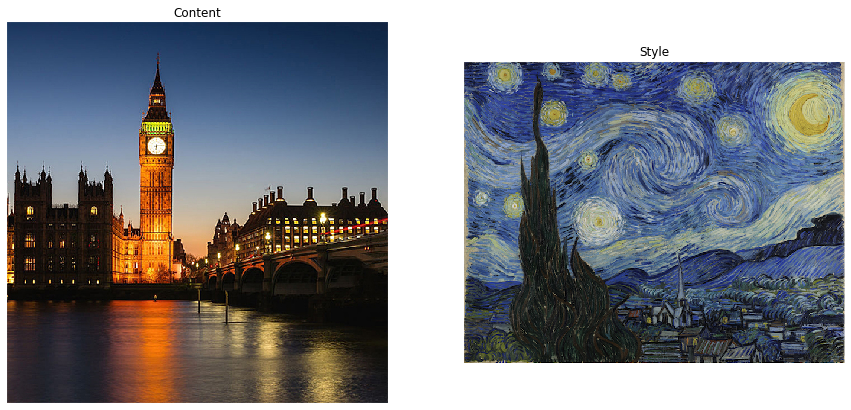

In [8]:
# how to load images from URLs?

content_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg")
style_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png")[..., :3] # removes transparency channel

print(content_image.shape, style_image.shape)

show_images([content_image, style_image], ['Content', 'Style'])

In [9]:
type(content_image)

numpy.ndarray

The InceptionV1 layers from TF are like this: (compare with the Pytorch model)

```
[Layer (belonging to InceptionV1) <conv2d0: 64> ([{'conv'}]),
  Layer (belonging to InceptionV1) <conv2d1: 64> ([{'conv'}]),
  Layer (belonging to InceptionV1) <conv2d2: 192> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed3a: 256> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed3b: 480> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4a: 508> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4b: 512> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4c: 512> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4d: 528> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed4e: 832> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed5a: 832> ([{'conv'}]),
  Layer (belonging to InceptionV1) <mixed5b: 1024> ([{'conv'}]),
  Layer (belonging to InceptionV1) <head0_bottleneck: 128> ([{'conv'}]),
  Layer (belonging to InceptionV1) <nn0: 1024> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax0: 1008> ([{'dense'}]),
  Layer (belonging to InceptionV1) <head1_bottleneck: 128> ([{'conv'}]),
  Layer (belonging to InceptionV1) <nn1: 1024> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax1: 1008> ([{'dense'}]),
  Layer (belonging to InceptionV1) <softmax2: 1008> ([{'dense'}])]
 19
 ```
 
 And the layers to plug into are:
 ```
 style_layers = [
  'conv2d2',  # conv3
  'mixed3a',  # inception3a
  'mixed4a',  # inception3b
  'mixed4b',  # inception4b
  'mixed4c',  # inception4c
]

content_layers = [
  'mixed3b',  # inception3b
]
 ```

In [10]:
print('\n'.join(model._modules.keys()))

conv1
maxpool1
conv2
conv3
maxpool2
inception3a
inception3b
maxpool3
inception4a
inception4b
inception4c
inception4d
inception4e
maxpool4
inception5a
inception5b
avgpool
dropout
fc


In [11]:
model
model.transform_input = False

In [12]:
len(model._modules)

19

In [13]:
style_layers = [
  'conv3',
  'inception3a',
  'inception4a',
  'inception4b',
  'inception4c',
]

content_layers = [
  'inception3b',
]

In [14]:
arch = LayeredModule.from_custom_model(model)

In [15]:
#arch.prep

In [16]:
from fastai.layers import Lambda

arch.prepend('normalization', Lambda(lambda x: 2*x - 1)) #center the values of Google net

In [17]:
arch

LayeredModule(
  (layers): ModuleDict(
    (normalization): Lambda()
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride

In [18]:
list(arch.layers.keys())

['normalization',
 'conv1',
 'maxpool1',
 'conv2',
 'conv3',
 'maxpool2',
 'inception3a',
 'inception3b',
 'maxpool3',
 'inception4a',
 'inception4b',
 'inception4c',
 'inception4d',
 'inception4e',
 'maxpool4',
 'inception5a',
 'inception5b',
 'avgpool',
 'flatten',
 'dropout',
 'fc']

In [19]:
min(content_image.shape[:2])

512

In [20]:
#arch.prepend('image_param', image_param)

In [21]:
import torchvision.transforms as T

def transform_inputs(content_image, style_image):
    content_tfms = T.ToTensor()
    content_input = content_tfms(content_image).unsqueeze(0)
    # content_input = norm(content_tfms(content_image), input_range=(0, 1), grad=False)
    style_tfms = T.Compose([T.ToPILImage(), T.RandomCrop(content_image.shape[:2]), T.ToTensor()])
    style_input = style_tfms(style_image).unsqueeze(0)
    # style_input = norm(style_tfms(style_image), input_range=(0, 1), grad=False)
    return content_input, style_input

In [22]:
content_input, style_input = transform_inputs(content_image, style_image)

In [23]:
content_input.shape, content_input.max()

content_input = content_input.cuda()
style_input = style_input.cuda()

content_input.device


device(type='cuda', index=0)

In [24]:
import torch.nn.functional as F

style_module = StyleTransferModule(arch, content_input, content_layers, style_input, style_layers, loss_func=F.l1_loss)

In [25]:
class STCallback(OptVisCallback):
    def on_step_end(self, optvis, img, *args, **kwargs):
        if optvis.is_step_to_show():
            print(f'Style loss={optvis.objective.style_loss}, Content loss={optvis.objective.content_loss}, TV loss={optvis.objective.tv_loss}')

In [26]:
style_obj = StyleTransferObjective(style_module, style_weight=100, content_weight=1)

In [27]:
import torch.optim
from visualization.generation.render import *

optvis = OptVis(style_module, style_obj, optim=optim.LBFGS)

In [28]:
content_image.shape

(512, 512, 3)

In [29]:
# we need to pre-prend the "layer" of the parameterization
from visualization.generation import param

image_param = param.ImageParam(content_image.shape[:2], fft=True, decorrelate=True)

Run [50], loss=4.5524
Style loss=4.276539325714111, Content loss=0.27590852975845337, TV loss=0.0
Run [100], loss=4.4436


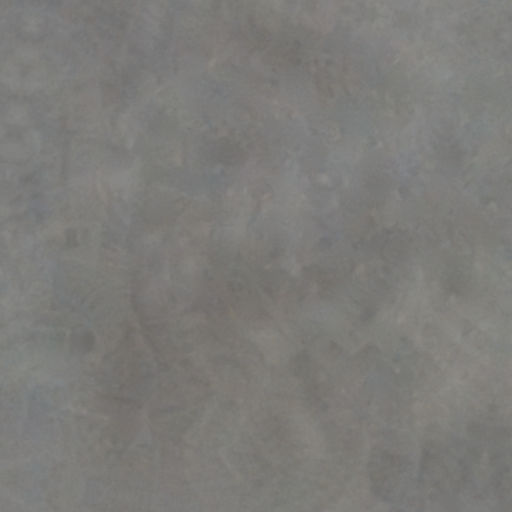

Style loss=4.168849468231201, Content loss=0.2747275233268738, TV loss=0.0
Run [150], loss=4.4608
Style loss=4.18547248840332, Content loss=0.2753475308418274, TV loss=0.0
Run [200], loss=4.2279


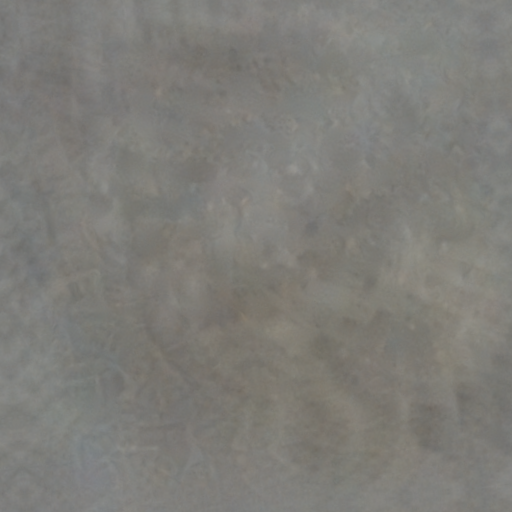

Style loss=3.9528493881225586, Content loss=0.27501994371414185, TV loss=0.0
Run [250], loss=4.0206
Style loss=3.747485876083374, Content loss=0.2730976343154907, TV loss=0.0


KeyboardInterrupt: 

In [30]:
output = optvis.vis(image_param, thresh=(100,200,300,400,500,), transform=True, in_closure=True, show=True, callback=STCallback())

In [ ]:
#trials = [10000, 140000, 160000]

In [ ]:
output = image_param()

In [ ]:
show_images([output], ['Output Image'])